In [2]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
from sklearn.cluster import KMeans,DBSCAN
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_supervisor = pd.read_csv("./Data/직무능력평가.CSV",engine="python")
ds_supervisor.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


# 데이터 전처리 - Scaling
- **데이터 표준화**

In [5]:
scaler = StandardScaler()
# 데이터 표준화 변환
ds_supervisor_sacaled= scaler.fit_transform(ds_supervisor)
ds_supervisor_sacaled[:5]

array([[-1.8076031 , -1.19166169, -1.92300586, -1.50494461, -0.35542617,
         1.77141034,  0.20430138],
       [-0.13647543, -0.19861028, -0.17733772, -0.20508842, -0.15977874,
        -0.18159526,  0.4020124 ],
       [ 0.53197564,  0.25972114,  1.23582221,  1.09476777,  1.11192959,
         1.15467173,  0.50086791],
       [-0.30358819, -0.27499885, -0.67610004, -0.81168798, -1.0401922 ,
         0.9490922 , -0.78425369],
       [ 1.36753948,  0.87082969,  0.23829756,  0.83479653,  0.622811  ,
         0.84630243,  0.4020124 ]])

# 데이터전처리 - 역할 정의
-**y : 목표변수**<br>
-**x : 설명변수**

In [7]:
ds_supervisor_y = ds_supervisor_sacaled[:,0]
ds_supervisor_x = ds_supervisor_sacaled[:,1::]

# Dendrogram

Text(0, 0.5, 'sample index')

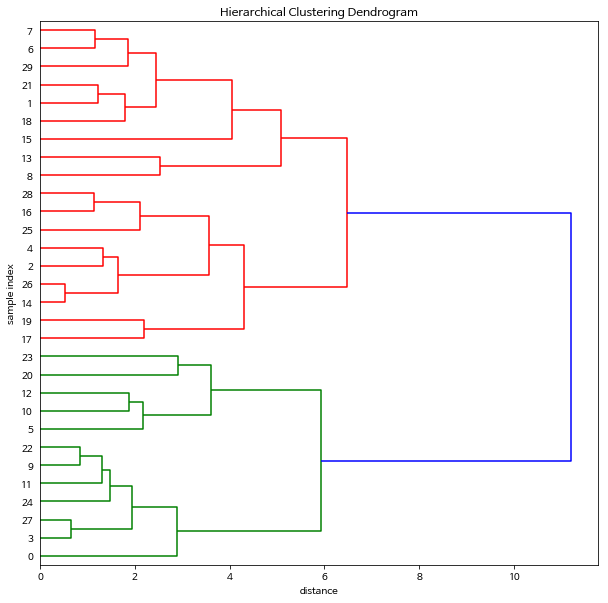

In [9]:
# 연결 : ward, 거리 계산 : Euclidean
Z_ward = linkage(ds_supervisor_x,method="ward", metric = "euclidean")
# 연결 : average, 거리 계산 : Euclidean
Z_average = linkage(ds_supervisor_x,method="average", metric = "euclidean")
# 연결 average, 거리 계산 : minkowski
Z_Minkowski = linkage(ds_supervisor_x,method="average",metric="minkowski")
# 덴드로그램 [연결: ward , 거리 계산 : Euclidean]
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
dendrogram(Z_ward,leaf_font_size=10,orientation="right")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
plt.ylabel("sample index")

# 계층형 군집 생성

In [10]:
# linkage 함수를 통해 얻은 Z_ward 행렬 데이터를 이용해 군집 생성
cluster_hierarchical = fcluster(Z = Z_ward, t=5, criterion="distance")
# 데이터에 계층형 군집 결과 입력
ds_supervisor["ClusterHierarchical"] = cluster_hierarchical

# 군집별 데이터 요약
- **각 군집별 변수들이 다른 통계량값들을 갖고 있음**

In [11]:
# 집계 함수를 이용한 군집별 데이터 요약
ds_summary_hc = ds_supervisor.groupby("ClusterHierarchical").agg(["min","mean","max"])
# 집계 함수를 이용할 경우 열 이름이 두 줄에 걸쳐 나오므로 한 줄로 변환
level0 = ds_summary_hc.columns.get_level_values(0)
level1 = ds_summary_hc.columns.get_level_values(1)
ds_summary_hc.columns = level0 + "_" + level1
ds_summary_hc.reset_index(inplace = True)
ds_summary_hc.round(3)

,ClusterHierarchical,EVAL_min,EVAL_mean,EVAL_max,DISSATIS_min,DISSATIS_mean,DISSATIS_max,PRIVILEGE_min,PRIVILEGE_mean,PRIVILEGE_max,...,CHANCE_max,ADVANCE_min,ADVANCE_mean,ADVANCE_max,CRITISM_min,CRITISM_mean,CRITISM_max,PROMOTION_min,PROMOTION_mean,PROMOTION_max
0,1,43,57.429,67,51,58.857,66,30,43.571,52,...,50,51,59.429,66,74,81.143,92,33,38.571,45
1,2,40,53.200,69,37,49.400,62,33,46.800,57,...,58,43,52.000,58,49,60.000,67,25,35.000,49
2,3,50,71.889,85,58,73.889,85,54,63.333,71,...,75,55,74.333,88,74,79.000,86,46,54.667,72
3,4,68,70.000,72,82,82.500,83,72,77.500,83,...,67,59,65.000,71,77,80.000,83,31,33.000,35
4,5,58,69.143,82,61,72.714,90,39,47.143,52,...,72,60,66.286,75,54,72.000,85,35,40.714,47


# K 평균 군집분석
- **군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합**

In [15]:
# 최대 군집 생성 개수
n_iter_cluster = 15
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for n_clus in cluster_range:
    clus = KMeans(n_clus)
    clus.fit(ds_supervisor_x)
    # 각 데이터로부터 가장 가까운 군집 중심점까지 거리 제곱 합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({"NumberofCluster": cluster_range, "Error":clus_error})
ds_error.round(3)

,NumberofCluster,Error
0,1,180.000
1,2,114.083
2,3,93.637
3,4,78.730
4,5,68.904
5,6,58.136
6,7,48.428
7,8,45.394
8,9,36.122
9,10,32.210


# K 평균 군집분석
- **군집별 군집 중심점까지 거리 제곱합을 시각화**

Text(0, 0.5, 'Sum of squared distnace')

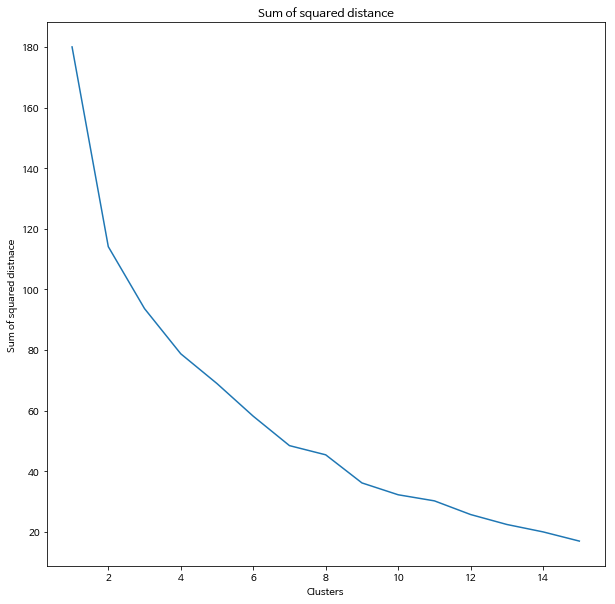

In [16]:
plt.figure(figsize=(10,10))
plt.plot(ds_error["NumberofCluster"],ds_error["Error"])
plt.title("Sum of squared distance")
plt.xlabel("Clusters")
plt.ylabel("Sum of squared distnace")